# Stage 2 Analysis Notebook

Analyze stage 2 (sDSR) training: loss decay, recon/focal/sub decomposition, validation metrics, and visual diagnostics to understand why loss stays high (especially the subspace term) when following paper parameters.

In [1]:
# Setup and paths
import sys
from pathlib import Path

# Project root: run notebook from repo root, or from notebooks/ (then parent is root)
_cwd = Path(".").resolve()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
sys.path.insert(0, str(PROJECT_ROOT))

import re
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Paths (match scripts/train.py: stage2 uses stage1_ckpt, ckpt_dir/stage2/machine_type)
CKPT_DIR = PROJECT_ROOT / "checkpoints"
MACHINE_TYPE = "fan"
STAGE1_CKPT = CKPT_DIR / "stage1" / MACHINE_TYPE / "stage1_fan_best.pt"
if not STAGE1_CKPT.exists():
    STAGE1_CKPT = CKPT_DIR / "stage1" / "ToyCar+ToyConveyor+fan+pump+slider+valve" / "stage1_ToyCar+ToyConveyor+fan+pump+slider+valve_final.pt"
STAGE2_CKPT = CKPT_DIR / "stage2" / MACHINE_TYPE / "stage2_fan_best.pt"
STAGE2_FINAL_CKPT = CKPT_DIR / "stage2" / MACHINE_TYPE / "stage2_fan_final.pt"
# DCASE data for validation/dataloader (same as training)
DATA_PATH = PROJECT_ROOT / ".." / "data" / "dcase2020-task2-dev-dataset"  # or Path("/path/to/dcase2020-task2-dev-dataset")
if not DATA_PATH.exists():
    DATA_PATH = None

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
print(f"Stage1 checkpoint exists: {STAGE1_CKPT.exists()}")
print(f"Stage2 best checkpoint exists: {STAGE2_CKPT.exists()}")

Device: cuda
Stage1 checkpoint exists: True
Stage2 best checkpoint exists: True


## 1. Parse training log

Paste your training stdout below, or set `LOG_FILE` to a path (e.g. `train_stage2_fan.log`). Parsed arrays: `steps`, `loss_total`, `loss_recon`, `loss_focal`, `loss_sub`, `lr`.

In [2]:
# Training log: BaseTrainer writes to ckpt_dir/train.log (stage2 ckpt_dir = checkpoints/stage2/<machine_type>)
LOG_FILE = CKPT_DIR / "stage2" / MACHINE_TYPE / "train.log"
PASTED_LOG = """
[   100] loss=8.2549  recon=0.7530  focal=0.0768  sub=0.6483  lr=5.05e-05  (4.6 it/s)
[   200] loss=4.2165  recon=0.3612  focal=0.0338  sub=0.5706  lr=1.50e-04  (4.7 it/s)
[  1000] loss=2.9148  recon=0.2368  focal=0.0251  sub=0.5219  lr=1.97e-04  (4.7 it/s)
[ 10000] loss=2.2876  recon=0.1821  focal=0.0132  sub=0.4531  lr=1.02e-06  (4.7 it/s)
"""

def parse_stage2_log(log_text: str):
    pattern = re.compile(
        r"\[\s*(\d+)\].*?loss=([\d.]+)\s+recon=([\d.]+)\s+focal=([\d.]+)\s+sub=([\d.]+).*?lr=([\d.e+-]+)"
    )
    steps, loss_total, loss_recon, loss_focal, loss_sub, lr = [], [], [], [], [], []
    for m in pattern.finditer(log_text):
        steps.append(int(m.group(1)))
        loss_total.append(float(m.group(2)))
        loss_recon.append(float(m.group(3)))
        loss_focal.append(float(m.group(4)))
        loss_sub.append(float(m.group(5)))
        lr.append(float(m.group(6)))
    return (
        np.array(steps),
        np.array(loss_total),
        np.array(loss_recon),
        np.array(loss_focal),
        np.array(loss_sub),
        np.array(lr),
    )

if LOG_FILE and Path(LOG_FILE).exists():
    log_text = Path(LOG_FILE).read_text()
else:
    log_text = PASTED_LOG

steps, loss_total, loss_recon, loss_focal, loss_sub, lr = parse_stage2_log(log_text)
if len(steps) > 0:
    print(f"Parsed {len(steps)} log lines (steps: {steps.min()}-{steps.max()})")
else:
    print("Parsed 0 log lines.")
if len(steps) > 0:
    print(f"  total: {loss_total[-1]:.4f}, recon: {loss_recon[-1]:.4f}, focal: {loss_focal[-1]:.4f}, sub: {loss_sub[-1]:.4f}")

Parsed 100 log lines (steps: 100-10000)
  total: 0.8957, recon: 0.0782, focal: 0.0073, sub: 0.1063


## 2. Loss curves

- **Total loss vs step**: confirm slow decay and plateau.
- **Raw terms**: recon, focal, sub (sub often plateaus while recon keeps decreasing).
- **Weighted contributions**: `10*recon`, `1*focal`, `1*sub` to see which term dominates total.
- **Learning rate vs step**: warmup (first 200 iters) and cosine decay to 1e-6.

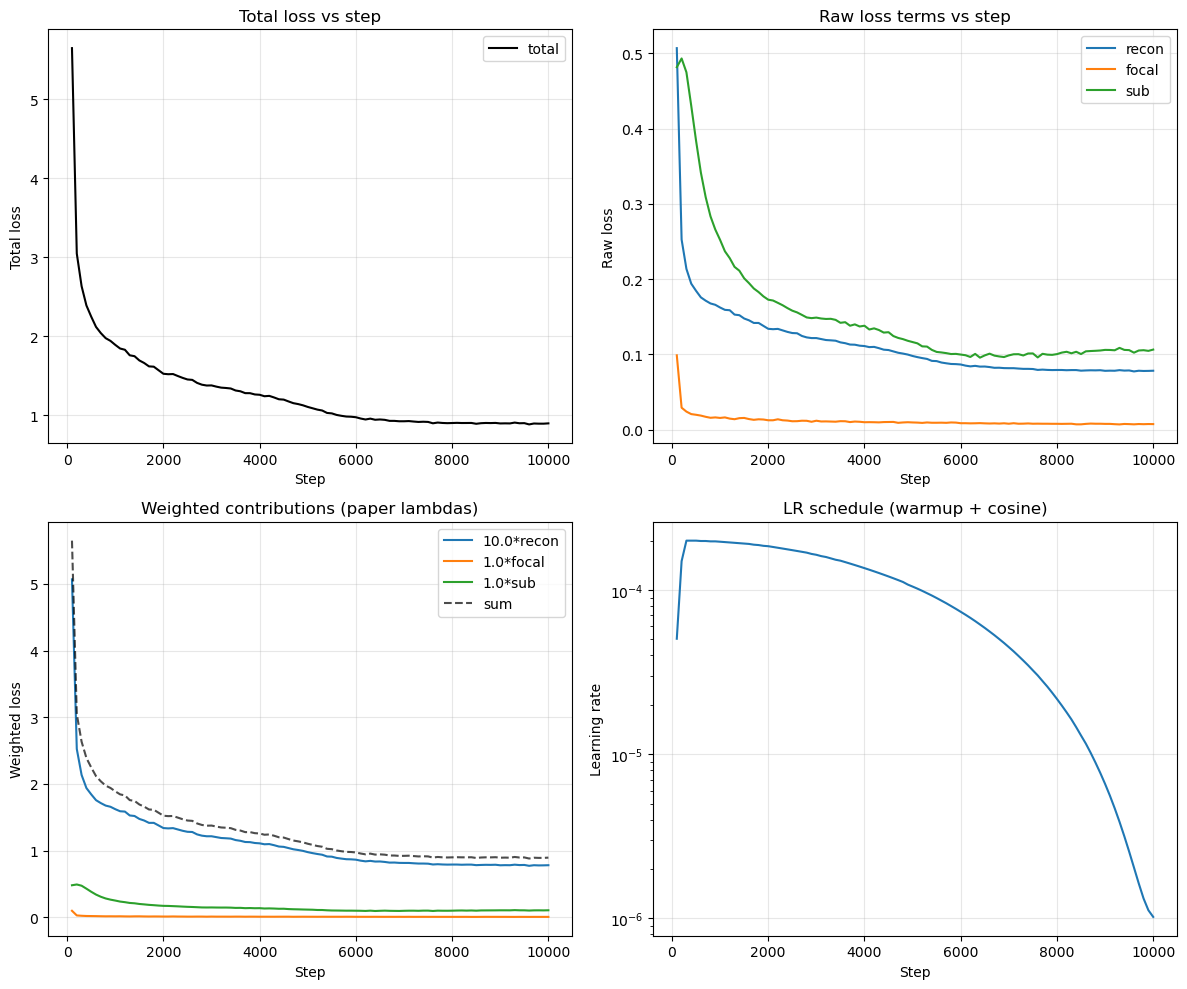

In [3]:
# Paper lambdas (same as stage2 trainer)
LAMBDA_RECON, LAMBDA_FOCAL, LAMBDA_SUB = 10.0, 1.0, 1.0

if len(steps) == 0:
    print("No parsed log data. Paste full log in PASTED_LOG or set LOG_FILE.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Total loss vs step
    ax = axes[0, 0]
    ax.plot(steps, loss_total, color="black", label="total")
    ax.set_xlabel("Step")
    ax.set_ylabel("Total loss")
    ax.set_title("Total loss vs step")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Raw terms vs step
    ax = axes[0, 1]
    ax.plot(steps, loss_recon, label="recon")
    ax.plot(steps, loss_focal, label="focal")
    ax.plot(steps, loss_sub, label="sub")
    ax.set_xlabel("Step")
    ax.set_ylabel("Raw loss")
    ax.set_title("Raw loss terms vs step")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Weighted contributions
    ax = axes[1, 0]
    w_recon = LAMBDA_RECON * loss_recon
    w_focal = LAMBDA_FOCAL * loss_focal
    w_sub = LAMBDA_SUB * loss_sub
    ax.plot(steps, w_recon, label=f"{LAMBDA_RECON}*recon")
    ax.plot(steps, w_focal, label=f"{LAMBDA_FOCAL}*focal")
    ax.plot(steps, w_sub, label=f"{LAMBDA_SUB}*sub")
    ax.plot(steps, w_recon + w_focal + w_sub, "k--", alpha=0.7, label="sum")
    ax.set_xlabel("Step")
    ax.set_ylabel("Weighted loss")
    ax.set_title("Weighted contributions (paper lambdas)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # LR vs step
    ax = axes[1, 1]
    ax.semilogy(steps, lr)
    ax.set_xlabel("Step")
    ax.set_ylabel("Learning rate")
    ax.set_title("LR schedule (warmup + cosine)")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 3. Load model and validation-style metrics

Load stage1 and stage2 checkpoints (same build as `scripts/train.py` run_stage2), then run N batches without gradients on **AudDSRAnomTrainDataset** with `forward_train(x, M_gt=M_gt)` to compute average recon/focal/sub (and optional sub_top / sub_bot) with the same lambdas as training.

In [4]:
# Build model (same as scripts/train.py run_stage2)
from src.models.vq_vae.autoencoders import VQ_VAE_2Layer
from src.models.sDSR.s_dsr import sDSR, sDSRConfig
from src.models.sDSR.loss import FocalLoss

def build_vq_vae(n_mels: int, T: int):
    return VQ_VAE_2Layer(
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        num_embeddings=(1024, 4096),
        embedding_dim=128,
        commitment_cost=0.25,
        decay=0.99,
    )

def build_s_dsr(vq_vae, n_mels: int, T: int):
    cfg = sDSRConfig(
        embedding_dim=128,
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        n_mels=n_mels,
        T=T,
    )
    return sDSR(vq_vae, cfg)

n_mels, T = 128, 320
if DATA_PATH is not None:
    from src.data.dataset import DCASE2020Task2LogMelDataset
    _ds = DCASE2020Task2LogMelDataset(root=str(DATA_PATH), machine_type=MACHINE_TYPE, normalize=True)
    _, _, n_mels, T = _ds.data.shape

vq_vae = build_vq_vae(n_mels, T)
ckpt_s1 = torch.load(STAGE1_CKPT, map_location="cpu", weights_only=True)
vq_vae.load_state_dict(ckpt_s1["model_state_dict"])

model = build_s_dsr(vq_vae, n_mels, T)
ckpt_s2 = torch.load(STAGE2_CKPT, map_location="cpu", weights_only=True)
model.load_state_dict(ckpt_s2["model_state_dict"])
model = model.to(DEVICE)
model.eval()

focal_loss_fn = FocalLoss(gamma=2.0)
print("Model loaded.")

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM
Model loaded.


In [5]:
# Validation loop: same dataset and losses as trainer (AudDSRAnomTrainDataset, forward_train(x, M_gt=M_gt))
from torch.utils.data import DataLoader

if DATA_PATH is None:
    print("Set DATA_PATH to run validation loop (e.g. path to DCASE root).")
else:
    from src.data.dataset import DCASE2020Task2LogMelDataset, AudDSRAnomTrainDataset
    q_vae_dataset = DCASE2020Task2LogMelDataset(root=str(DATA_PATH), machine_type=MACHINE_TYPE, normalize=True)
    val_dataset = AudDSRAnomTrainDataset(q_vae_dataset, strategy="both", zero_mask_prob=0.5)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=True)
    n_val_batches = min(100, len(val_loader))

    accum = {"total": 0.0, "recon": 0.0, "focal": 0.0, "sub": 0.0, "sub_top": 0.0, "sub_bot": 0.0}
    n_sub_top_bot = 0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= n_val_batches:
                break
            x = batch["image"].to(DEVICE)
            M_gt = batch["anomaly_mask"].to(DEVICE)
            if M_gt.dim() == 3:
                M_gt = M_gt.unsqueeze(1)
            out = model.forward_train(x, M_gt=M_gt)
            loss_recon = F.mse_loss(out["x"], out["x_s"]).item()
            loss_focal = focal_loss_fn(out["m_out"], out["M"]).item()
            if "recon_feat_bot" in out and "recon_feat_top" in out and "q_bot" in out and "q_top" in out:
                loss_sub_bot = F.mse_loss(out["recon_feat_bot"], out["q_bot"].detach()).item()
                loss_sub_top = F.mse_loss(out["recon_feat_top"], out["q_top"].detach()).item()
                loss_sub = 0.5 * loss_sub_bot + 0.5 * loss_sub_top
                accum["sub_top"] += loss_sub_top
                accum["sub_bot"] += loss_sub_bot
                n_sub_top_bot += 1
            else:
                loss_sub = 0.0
            total = LAMBDA_RECON * loss_recon + LAMBDA_FOCAL * loss_focal + LAMBDA_SUB * loss_sub
            accum["total"] += total
            accum["recon"] += loss_recon
            accum["focal"] += loss_focal
            accum["sub"] += loss_sub

    n = n_val_batches
    for k in ["total", "recon", "focal", "sub"]:
        accum[k] /= n
    if n_sub_top_bot:
        accum["sub_top"] /= n_sub_top_bot
        accum["sub_bot"] /= n_sub_top_bot
    print("Validation (no grad, same lambdas, AudDSRAnomTrainDataset):")
    print(f"  total = {accum['total']:.4f}, recon = {accum['recon']:.4f}, focal = {accum['focal']:.4f}, sub = {accum['sub']:.4f}")
    if n_sub_top_bot:
        print(f"  sub_top = {accum['sub_top']:.4f}, sub_bot = {accum['sub_bot']:.4f}")

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM
Validation (no grad, same lambdas, AudDSRAnomTrainDataset):
  total = 0.9519, recon = 0.0823, focal = 0.0219, sub = 0.1071
  sub_top = 0.0700, sub_bot = 0.1442


## 4. Visual diagnostics

Plot input `x`, general recon `x_g`, object-specific recon `x_s`, difference `x_g - x_s`, GT mask `M`, and anomaly output `m_out` (e.g. softmax anomaly channel). Use one sample from a batch. Set DATA_PATH for real data; otherwise a random batch is used for layout only.

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM


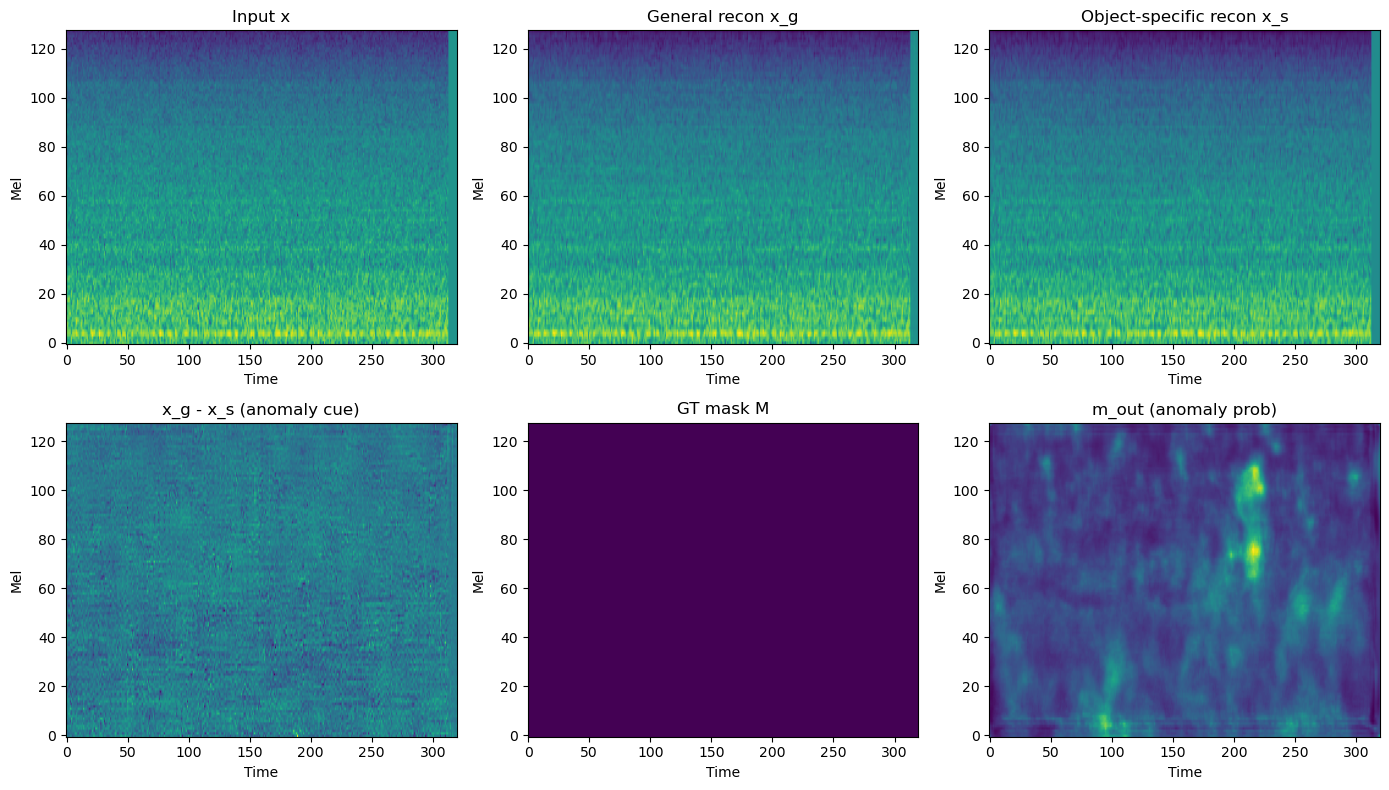

In [6]:
# Get one batch: from AudDSRAnomTrainDataset if DATA_PATH set (same as training), else random
if DATA_PATH is not None:
    from src.data.dataset import DCASE2020Task2LogMelDataset, AudDSRAnomTrainDataset
    from torch.utils.data import DataLoader
    _base = DCASE2020Task2LogMelDataset(root=str(DATA_PATH), machine_type=MACHINE_TYPE, normalize=True)
    _viz_ds = AudDSRAnomTrainDataset(_base, strategy="both", zero_mask_prob=0.5)
    _viz_loader = DataLoader(_viz_ds, batch_size=4, shuffle=True, num_workers=0)
    _batch = next(iter(_viz_loader))
    x_viz = _batch["image"].to(DEVICE)
    M_viz = _batch["anomaly_mask"].to(DEVICE)
    if M_viz.dim() == 3:
        M_viz = M_viz.unsqueeze(1)
else:
    x_viz = torch.randn(4, 1, n_mels, T, device=DEVICE)
    M_viz = torch.zeros(4, 1, n_mels, T, device=DEVICE)

with torch.no_grad():
    out_viz = model.forward_train(x_viz, M_gt=M_viz)

# Pick first sample
idx = 0
x_np = x_viz[idx, 0].cpu().numpy()
x_g_np = out_viz["x_g"][idx, 0].cpu().numpy()
x_s_np = out_viz["x_s"][idx, 0].cpu().numpy()
diff_np = (out_viz["x_g"] - out_viz["x_s"])[idx, 0].cpu().numpy()
M_np = out_viz["M"][idx, 0].cpu().numpy()
# m_out: (B, 2, H, W) logits -> anomaly prob
m_probs = F.softmax(out_viz["m_out"], dim=1)
m_anom_np = m_probs[idx, 1].cpu().numpy()  # anomaly channel

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes[0, 0].imshow(x_np, aspect="auto", origin="lower")
axes[0, 0].set_title("Input x")
axes[0, 1].imshow(x_g_np, aspect="auto", origin="lower")
axes[0, 1].set_title("General recon x_g")
axes[0, 2].imshow(x_s_np, aspect="auto", origin="lower")
axes[0, 2].set_title("Object-specific recon x_s")
axes[1, 0].imshow(diff_np, aspect="auto", origin="lower")
axes[1, 0].set_title("x_g - x_s (anomaly cue)")
axes[1, 1].imshow(M_np, aspect="auto", origin="lower")
axes[1, 1].set_title("GT mask M")
axes[1, 2].imshow(m_anom_np, aspect="auto", origin="lower")
axes[1, 2].set_title("m_out (anomaly prob)")
for ax in axes.flat:
    ax.set_xlabel("Time")
    ax.set_ylabel("Mel")
plt.tight_layout()
plt.show()

## 5. Optional: gradient norms

Run a few training steps and record total grad norm (or per-layer) before `optimizer.step()`. If sub loss is high but gradients are tiny, consider higher lr or different initialization for subspace modules.

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM


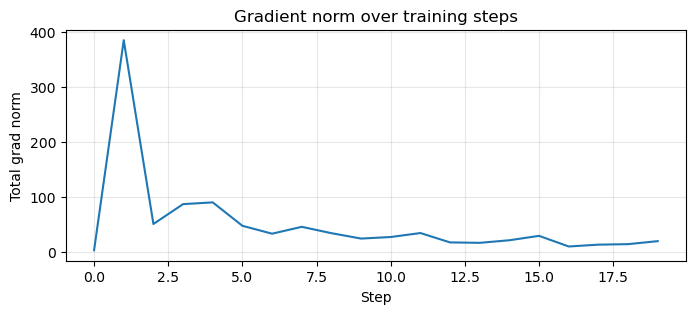

sDSR(
  (_vq_vae): VQ_VAE_2Layer(
    (_encoder_bot): EncoderBot(
      (_conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (_conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (_conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_residual): ResidualStack(
        (_layers): ModuleList(
          (0-1): 2 x Residual(
            (_block): Sequential(
              (0): ReLU()
              (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU()
              (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
    (_encoder_top): EncoderTop(
      (_conv1): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_residual): ResidualStack(
        (_layers): ModuleList(
         

In [7]:
# Gradient norms over a few training steps (optional; same dataset and forward_train as trainer)
model.train()
trainable = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable, lr=2e-4)
focal_fn = FocalLoss(gamma=2.0)

if DATA_PATH is not None:
    from src.data.dataset import DCASE2020Task2LogMelDataset, AudDSRAnomTrainDataset
    from torch.utils.data import DataLoader
    _base = DCASE2020Task2LogMelDataset(root=str(DATA_PATH), machine_type=MACHINE_TYPE, normalize=True)
    _grad_ds = AudDSRAnomTrainDataset(_base, strategy="both", zero_mask_prob=0.5)
    _grad_loader = DataLoader(_grad_ds, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
    _grad_iter = iter(_grad_loader)
    grad_steps = min(20, len(_grad_loader))
else:
    _grad_iter = None
    grad_steps = 10

grad_norms = []
for step in range(grad_steps):
    if _grad_iter is not None:
        try:
            batch = next(_grad_iter)
        except StopIteration:
            _grad_iter = iter(_grad_loader)
            batch = next(_grad_iter)
        x_batch = batch["image"].to(DEVICE)
        M_batch = batch["anomaly_mask"].to(DEVICE)
        if M_batch.dim() == 3:
            M_batch = M_batch.unsqueeze(1)
    else:
        x_batch = torch.randn(16, 1, n_mels, T, device=DEVICE)
        M_batch = torch.zeros(16, 1, n_mels, T, device=DEVICE)
    optimizer.zero_grad(set_to_none=True)
    out = model.forward_train(x_batch, M_gt=M_batch)
    loss_recon = F.mse_loss(out["x"], out["x_s"])
    loss_focal = focal_fn(out["m_out"], out["M"])
    if "recon_feat_bot" in out and "q_bot" in out:
        loss_sub = 0.5 * F.mse_loss(out["recon_feat_bot"], out["q_bot"].detach()) + 0.5 * F.mse_loss(out["recon_feat_top"], out["q_top"].detach())
    else:
        loss_sub = torch.tensor(0.0, device=DEVICE)
    loss = LAMBDA_RECON * loss_recon + LAMBDA_FOCAL * loss_focal + LAMBDA_SUB * loss_sub
    loss.backward()
    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), float("inf"))
    grad_norms.append(total_norm.item())
    optimizer.step()

plt.figure(figsize=(8, 3))
plt.plot(grad_norms)
plt.xlabel("Step")
plt.ylabel("Total grad norm")
plt.title("Gradient norm over training steps")
plt.grid(True, alpha=0.3)
plt.show()
model.eval()

## 6. What to look for & paper parameters

### What to look for
- **Sub loss dominating and plateauing** → Subspace restriction is the bottleneck. Consider more iterations, different lr for subspace modules, or checking capacity of `SubspaceRestrictionModule`.
- **Recon high** → Object decoder reconstruction poor; check stage 1 quality first.
- **Focal high** → Anomaly detection head not matching M; check mask generation and alignment.

### Paper parameters (from scripts/train.py and Stage2Trainer)
- `lambda_recon=10`, `lambda_focal=1`, `lambda_sub=1`
- `lr=2e-4`, warmup 200 iters, cosine decay to `lr_min=1e-6`
- Batch size 16, grad_clip 1.0
- FocalLoss `gamma=2.0`
- Dataset: `AudDSRAnomTrainDataset(base, strategy="both", zero_mask_prob=0.5)`; batches are dicts with `"image"` and `"anomaly_mask"`; `forward_train(x, M_gt=M_gt)` required
- Total loss = 10*recon + 1*focal + 1*sub
- Training log: `checkpoints/stage2/<machine_type>/train.log`